In [1]:
from lib.BBMetrics import BBMetric
from transformers import TFAutoModelForCausalLM, AutoTokenizer
import os
from Data.data_dicts import character_dict, source_dict, random_state

import os
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive',force_remount=True)
    base_folder = '/content/drive/My Drive/unibo/NLP_project/BarneyBot'
    os.system("pip install datasets")
    os.system("pip install transformers")
    os.system("pip install rouge_score")
    os.system("pip install -U sentence-transformers")
else:
    base_folder = os.getcwd()

sentences1 = ["I love this! I think life is good without issues.", "The red fox jumps.", "Hi"]
sentences2 = ["I hate you.", "Hi"]

In [ ]:
model = TFAutoModelForCausalLM.from_pretrained('microsoft/DialoGPT-small', cache_dir=os.path.join(os.getcwd(), "cache"))
tokenizer = AutoTokenizer.from_pretrained('microsoft/DialoGPT-small', cache_dir=os.path.join(os.getcwd(), "cache"))
tokenizer.pad_token = '#'

In [2]:
BBMetric.metrics_list

['bleu',
 'semantic similarity',
 'rouge l',
 'emotion',
 'semantic answer similarity',
 'distinct',
 'semantic classifier',
 'perplexity',
 'human - coherence',
 'human - consistency',
 'human - style']

Loaded encoded lines from D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_encoded_lines.npy
Running shuffle 0/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7131.94it/s]


Running shuffle 1/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5054.19it/s]


Running shuffle 2/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10110.77it/s]


Running shuffle 3/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10132.56it/s]


Running shuffle 4/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7129.87it/s]


Running shuffle 5/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10102.29it/s]


Running shuffle 6/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10133.96it/s]


Running shuffle 7/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 5051.95it/s]


Running shuffle 8/10


100%|██████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 7145.09it/s]


Running shuffle 9/10


100%|█████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<00:00, 10103.83it/s]


Loading training data...


100%|██████████████████████████████████████████████████████████████████████████████████████| 2686/2686 [00:00<?, ?it/s]


Loading test data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 316/316 [00:00<?, ?it/s]


Loading validation data...


100%|████████████████████████████████████████████████████████████████████████████████████████| 158/158 [00:00<?, ?it/s]


Epoch 1/1000
168/168 [==============================] - 7s 33ms/step - loss: 0.9401 - binary_accuracy: 0.5123 - recall: 0.5227 - val_loss: 0.7130 - val_binary_accuracy: 0.5316 - val_recall: 0.9103
Epoch 2/1000
168/168 [==============================] - 6s 33ms/step - loss: 0.8861 - binary_accuracy: 0.5424 - recall: 0.5444 - val_loss: 0.7260 - val_binary_accuracy: 0.5949 - val_recall: 0.8718
Epoch 3/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.8213 - binary_accuracy: 0.5745 - recall: 0.5772 - val_loss: 0.6937 - val_binary_accuracy: 0.6266 - val_recall: 0.7692
Epoch 4/1000
168/168 [==============================] - 6s 33ms/step - loss: 0.7937 - binary_accuracy: 0.5845 - recall: 0.5809 - val_loss: 0.6504 - val_binary_accuracy: 0.6519 - val_recall: 0.7051
Epoch 5/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.7578 - binary_accuracy: 0.5983 - recall: 0.5988 - val_loss: 0.6148 - val_binary_accuracy: 0.6899 - val_recall: 0.7308
Epoch 6/1000
16

168/168 [==============================] - 7s 41ms/step - loss: 0.2307 - binary_accuracy: 0.9218 - recall: 0.9232 - val_loss: 0.1195 - val_binary_accuracy: 0.9873 - val_recall: 0.9872
Epoch 43/1000
168/168 [==============================] - 7s 41ms/step - loss: 0.2197 - binary_accuracy: 0.9285 - recall: 0.9374 - val_loss: 0.1160 - val_binary_accuracy: 0.9873 - val_recall: 0.9872
Epoch 44/1000
168/168 [==============================] - 7s 41ms/step - loss: 0.2223 - binary_accuracy: 0.9267 - recall: 0.9336 - val_loss: 0.1121 - val_binary_accuracy: 0.9937 - val_recall: 0.9872
Epoch 45/1000
168/168 [==============================] - 6s 34ms/step - loss: 0.2213 - binary_accuracy: 0.9315 - recall: 0.9366 - val_loss: 0.1072 - val_binary_accuracy: 1.0000 - val_recall: 1.0000
Epoch 46/1000
168/168 [==============================] - 6s 37ms/step - loss: 0.2196 - binary_accuracy: 0.9289 - recall: 0.9351 - val_loss: 0.1055 - val_binary_accuracy: 1.0000 - val_recall: 1.0000
Epoch 47/1000
168/168 [=

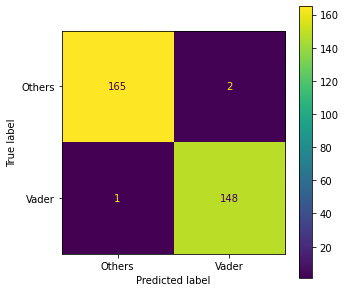

INFO:tensorflow:Assets written to: D:\University\Esami da Superare\Natural Language Processing\BarneyBot\BarneyBot\Data\Characters\Vader\vader_classifier_1000\assets


In [2]:
metric = BBMetric.load_metric("semantic classifier")

metric.train(character='Vader', character_dict=character_dict, source_dict=source_dict, random_state=random_state,
             base_folder=base_folder)

In [7]:
metric = BBMetric.load_metric("semantic classifier")

print(metric.compute(character='Vader', character_dict=character_dict, base_folder=base_folder,
               sentences=["We're doomed!", "Not again! Forget it.", "Don't worry about it, Wormie."]))
print(metric.compute(character='Vader', character_dict=character_dict, base_folder=base_folder,
               sentences=["Commander, tear this ship apart", "What have you done with thoseplans?",
                          "What is thy bidding, my Master?"]))

{'score': 0.64661723}
{'score': 0.40511295}


In [7]:
metric = BBMetric.load_metric("bleu")

print(metric.compute(predictions=sentences1, references=sentences2))

{'score': 0.0}


In [8]:
metric = BBMetric.load_metric("rouge l")

print(metric.compute(predictions=sentences1, references=sentences2))

{'score': 0.6666666666666666}


In [4]:
metric = BBMetric.load_metric("semantic similarity")

print(metric.compute(sentences_a=sentences1, sentences_b=sentences2))

{'scores': array([0.03812046, 0.9504694 ], dtype=float32)}


In [2]:
metric = BBMetric.load_metric("emotion")

print(metric.compute(sentences=sentences1))

{'scores': [0.6401270031929016, 0.36308011412620544], 'labels': ['joy', 'anger']}


In [3]:
metric = BBMetric.load_metric("semantic answer similarity")

print(metric.compute(predictions=sentences1, references=sentences2))

{'scores': array([0.0881714, 1.       ], dtype=float32)}


In [2]:
metric = BBMetric.load_metric("perplexity")

print(metric.compute(model=model, tokenizer=tokenizer, sentences=sentences1, stride=2)) # Stride is optional, defaults to 64

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:03<00:00,  3.03it/s]

{'score': 118088.06238195905}


In [3]:
metric = BBMetric.load_metric("human - coherence")

metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humancoherence.csv"),
             length=2)
metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humancoherence.csv"))

>> User:Hello!
DialoGPT: Hi!
>> User:I hate you.
DialoGPT: I hate you
How do you rate this conversation (0 to 5)? 2


{'score': 0.4}

In [2]:
metric = BBMetric.load_metric("human - consistency")

metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanconsistency.csv"))
metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanconsistency.csv"))

Question: Who are you?
DialoGPT: I'm here
Question: What is your name?
DialoGPT: I'm in.
Question: What is your job?
DialoGPT: I'm a software engineer.
Question: Where do you live?
DialoGPT: I'm in the US and I've never heard of this.
How do you rate these answers (0 to 5)? 4


{'score': 0.8}

In [4]:
metric = BBMetric.load_metric("human - style")

metric.train(model=model, tokenizer=tokenizer,
             filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanstyle.csv"),
             questions=["What are you wearing?", "Legendary"])
metric.compute(filepath=os.path.join(os.getcwd(), "Datasets", "Characters", "Default", "humanstyle.csv"))

Question: What are you wearing?
DialoGPT: I'm wearing a shirt.
Question: Legendary
DialoGPT: What is this? A crossover episode?
How do you rate these answers (0 to 5)? 1.5
Invalid score! Must be a single integer between 0 and 5!
How do you rate these answers (0 to 5)? 2


{'score': 0.4}

In [8]:
metric = BBMetric.load_metric("distinct")
metric.compute(sentences=sentences1, ngram_size=5)

{'score': 0.07352941176470588}